# MNIST Digits Classifier (Chapter 3 Exercises)

## Imports

In [891]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import joblib
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,\
                            ConfusionMatrixDisplay,DetCurveDisplay,f1_score,\
                            RocCurveDisplay,confusion_matrix
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin,_OneToOneFeatureMixin,BaseEstimator,clone
from scipy.ndimage import shift
from mltoolkit import dump_model

## Classes

In [872]:
class MyScaler(_OneToOneFeatureMixin,TransformerMixin,BaseEstimator):
    def __init__(self,scalertype:str=None):
        '''
        scalertype: str | {'std','minmax','skip'}, Default: None
        specifying the scaler to transform the data
        '''
        if scalertype: 
            if scalertype in ['std','minmax','skip']:
                self.scalertype = scalertype
            else:
                raise ValueError('Specify scaler correctly. Options:{"std","minmax","skip"}')
        else: self.scalertype = None
    def fit(self,X,y=None,scalertype:str=None):
        '''
        scalertype: str | {'std','minmax','skip'}, Default: None
        specifying the scaler to transform the data
        '''
        if scalertype:
            if self.scalertype != scalertype:
                self.scalertype = scalertype
        if self.scalertype == 'std':
            self.scaler = StandardScaler()
        elif self.scalertype == 'minmax':
            self.scaler = MinMaxScaler()
        elif self.scalertype == 'skip':
            return self
        else:
            raise ValueError('Specify scaler correctly. Options:{"std","minmax","skip"}')
        return self
    def transform(self,X,scalertype:str=None):
        '''
        scalertype: str | {'std','minmax'}, Default: None
        specifying the scaler to transform the data
        '''
        if scalertype:
            if self.scalertype != scalertype:
                self.scalertype = scalertype
        if self.scalertype == 'std':
            self.scaler = StandardScaler()
        elif self.scalertype == 'minmax':
            self.scaler = MinMaxScaler()
        elif self.scalertype == 'skip':
            if type(X) == pd.DataFrame:
                return X.values
            elif type(X) == np.ndarray:
                return X
        else:
            raise ValueError('Specify scaler correctly. Options:{"std","minmax","skip"}')
        return self.scaler.fit_transform(X)

## Loading Datasets

In [36]:
loadingpath = "Datasets\\"
joblib.dump(rawdata,loadingpath+'MNIST 784 rawdata.pkl',9)

['Datasets\\MNIST 784 rawdata.pkl']

## Preparing Datasets

In [37]:
X_train,X_test,y_train,y_test = train_test_split(rawdata['data'],rawdata['target'],
                                                 test_size=10000,train_size=60000,
                                                 random_state=42,stratify=rawdata['target'])

In [41]:
y_train = y_train.astype(np.uint8)
y_test = y_test.astype(np.uint8)

## Saving Datasets

In [46]:
savingpath = "Datasets\\"
joblib.dump(X_train,savingpath+"X_train.pkl",9)
joblib.dump(y_train,savingpath+"y_train.pkl",9)
joblib.dump(X_test,savingpath+"X_test.pkl",9)
joblib.dump(y_test,savingpath+"y_test.pkl",9)

['Datasets\\y_test.pkl']

In [47]:
del rawdata

## Exploring Data

In [55]:
X_train.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 41086 to 25906
Columns: 784 entries, pixel1 to pixel784
dtypes: float64(784)
memory usage: 359.3 MB


In [388]:
y_train.info(show_counts=True)

<class 'pandas.core.series.Series'>
Int64Index: 60000 entries, 41086 to 25906
Series name: class
Non-Null Count  Dtype
--------------  -----
60000 non-null  uint8
dtypes: uint8(1)
memory usage: 527.3 KB


## K-Nearest Neighbors Classifier

In [397]:
mnist_knn = KNeighborsClassifier()

In [385]:
mnist_knn.fit(X_train,y_train)

KNeighborsClassifier()

In [386]:
mnist_knn.score(X_train,y_train)

0.98145

In [387]:
mnist_knn.score(X_test,y_test)

0.9717

We can achieve at 97% accuracy with test dataset even without tuning the hyperparameters.\
The trained model seems to be not overfitting nor underfitting.

### Pipeline

We will still perform a grid search on the K-Nearest Neighbors algorithm to see if there's any chance of improving its performance.

Since the rawdata is already clean enough, we just need to provide a optional scaler in the pipeline.\
We will try later in grid search to see whether which is the best option in 'no scaling', 'standard scaling' and 'minmax scaling'.

In [875]:
mnist_pipeline = Pipeline([
    ('scaler',MyScaler('skip')),
    ('knn',KNeighborsClassifier())
])

In [874]:
mnist_pipeline.get_params()

{'memory': None,
 'steps': [('scaler', MyScaler(scalertype='skip')),
  ('knn', KNeighborsClassifier())],
 'verbose': False,
 'scaler': MyScaler(scalertype='skip'),
 'knn': KNeighborsClassifier(),
 'scaler__scalertype': 'skip',
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 5,
 'knn__p': 2,
 'knn__weights': 'uniform'}

Due to the lack of computing resources, I will perform the grid search on each hyperparameter separately instead of testing all permutations between all required hyperparameters.

In [398]:
param_grid = [
    {"scaler__scalertype":['skip','std','minmax']},
    {"knn__weights":['uniform', 'distance']},
    {"knn__n_neighbors":[x for x in range(1,11) if x%2 == 1]},
]

In [422]:
mnist_knn_grid = GridSearchCV(mnist_pipeline,param_grid,scoring='accuracy',refit=False,cv=4)

In [423]:
mnist_knn_grid.fit(X_train,y_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('scaler', MyScaler(scalertype='skip')),
                                       ('knn', KNeighborsClassifier())]),
             param_grid=[{'scaler__scalertype': ['skip', 'std', 'minmax']},
                         {'knn__weights': ['uniform', 'distance']},
                         {'knn__n_neighbors': [1, 3, 5, 7, 9]}],
             refit=False, scoring='accuracy')

In [424]:
mnist_knn_grid_results = pd.DataFrame(mnist_knn_grid.cv_results_)
mnist_knn_grid_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_scaler__scalertype,param_knn__weights,param_knn__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.239426,0.006546,15.247418,0.907628,skip,NaN,NaN,{'scaler__scalertype': 'skip'},0.969533,0.968867,0.967933,0.968267,0.968650,0.000610,4
1,2.828773,1.223770,18.200878,0.407011,std,NaN,NaN,{'scaler__scalertype': 'std'},0.943867,0.942067,0.941600,0.941333,0.942217,0.000988,10
2,1.264761,0.704449,19.663743,3.994571,minmax,NaN,NaN,{'scaler__scalertype': 'minmax'},0.969533,0.968867,0.967933,0.968267,0.968650,0.000610,4
3,0.243794,0.006640,16.001071,0.274659,NaN,uniform,NaN,{'knn__weights': 'uniform'},0.969533,0.968867,0.967933,0.968267,0.968650,0.000610,4
4,0.255869,0.007358,15.179109,0.565073,NaN,distance,NaN,{'knn__weights': 'distance'},0.971333,0.970467,0.968667,0.969600,0.970017,0.000991,1
5,0.543019,0.521275,17.637225,2.343069,NaN,NaN,1,{'knn__n_neighbors': 1},0.972400,0.970933,0.967067,0.968067,0.969617,0.002144,3
6,0.530544,0.503760,15.460953,0.696159,NaN,NaN,3,{'knn__n_neighbors': 3},0.971333,0.970333,0.968800,0.968133,0.969650,0.001257,2
7,0.545825,0.521187,17.688625,2.236860,NaN,NaN,5,{'knn__n_neighbors': 5},0.969533,0.968867,0.967933,0.968267,0.968650,0.000610,4
8,0.577769,0.510216,16.956548,2.365437,NaN,NaN,7,{'knn__n_neighbors': 7},0.969533,0.967933,0.967067,0.965467,0.967500,0.001470,8
9,0.404302,0.008217,15.245272,0.493897,NaN,NaN,9,{'knn__n_neighbors': 9},0.968867,0.966200,0.966267,0.965667,0.966750,0.001244,9


In [428]:
mnist_knn_grid_scaler_results = mnist_knn_grid_results.iloc[0:3,:][['param_scaler__scalertype','mean_test_score']]
mnist_knn_grid_scaler_results

,param_scaler__scalertype,mean_test_score
0,skip,0.968650
1,std,0.942217
2,minmax,0.968650


<Figure size 720x432 with 0 Axes>

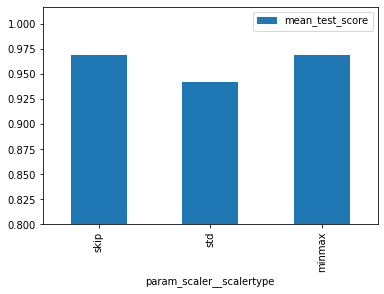

Best scaler type: skip
Best score: 0.96865


In [440]:
f = plt.figure(figsize=(10,6))
ax = mnist_knn_grid_scaler_results.plot(kind='bar',x='param_scaler__scalertype',y='mean_test_score')
plt.ylim(0.8,)
plt.show()
print('Best scaler type:',mnist_knn_grid_scaler_results['param_scaler__scalertype'][mnist_knn_grid_scaler_results['mean_test_score'].argmax()])
print('Best score:',mnist_knn_grid_scaler_results['mean_test_score'].max())

In [442]:
mnist_knn_grid_weights_results = mnist_knn_grid_results.iloc[3:5,:][['param_knn__weights','mean_test_score']]
mnist_knn_grid_weights_results

,param_knn__weights,mean_test_score
3,uniform,0.968650
4,distance,0.970017


<Figure size 720x432 with 0 Axes>

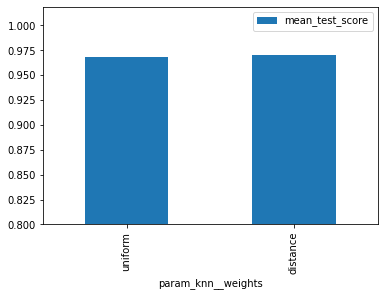

Best weight: distance
Best score: 0.9700166666666667


In [445]:
f = plt.figure(figsize=(10,6))
ax = mnist_knn_grid_weights_results.plot(kind='bar',x='param_knn__weights',y='mean_test_score')
plt.ylim(0.8,)
plt.show()
print('Best weight:',mnist_knn_grid_weights_results['param_knn__weights'].iloc[mnist_knn_grid_weights_results['mean_test_score'].argmax()])
print('Best score:',mnist_knn_grid_weights_results['mean_test_score'].max())

In [447]:
mnist_knn_grid_neighbors_results = mnist_knn_grid_results.iloc[5:,:][['param_knn__n_neighbors','mean_test_score']]
mnist_knn_grid_neighbors_results

,param_knn__n_neighbors,mean_test_score
5,1,0.969617
6,3,0.969650
7,5,0.968650
8,7,0.967500
9,9,0.966750


<Figure size 720x432 with 0 Axes>

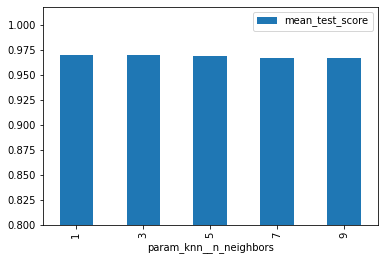

Best n-neighbors: 3
Best score: 0.96965


In [449]:
f = plt.figure(figsize=(10,6))
ax = mnist_knn_grid_neighbors_results.plot(kind='bar',x='param_knn__n_neighbors',y='mean_test_score')
plt.ylim(0.8,)
plt.show()
print('Best n-neighbors:',mnist_knn_grid_neighbors_results['param_knn__n_neighbors'].iloc[mnist_knn_grid_neighbors_results['mean_test_score'].argmax()])
print('Best score:',mnist_knn_grid_neighbors_results['mean_test_score'].max())

**Conclusion**:

Looks like the best hyperparameters for KNN algorithm are as follow:\
Scaler Type: 'Skip' (No Scaling)\
knn__weights: 'distance'\
knn__n_neighbors: 3

In [451]:
mnist_knn_best_score_found = mnist_knn_grid_results['mean_test_score'].max()
mnist_knn_best_score_found

0.9700166666666667

We can see that the best score ever found from grid search is around 97%.\
Don't forget thisscore is found by using only one of the best parameters (due to lack of computing resources).\
Let's see now we refit the best found parameters to the algorithm and see if it actually performs even better with cross validation of 4-folds.

In [453]:
mnist_knn_best_params = {
    'scaler__scalertype': 'skip',
    'knn__weights': 'distance',
    'knn__n_neighbors': 3
}

In [877]:
mnist_knn_best_pipeline = clone(mnist_pipeline).set_params(scaler__scalertype='skip',knn__weights='distance',knn__n_neighbors=3)
mnist_knn_best_pipeline

Pipeline(steps=[('scaler', MyScaler(scalertype='skip')),
                ('knn',
                 KNeighborsClassifier(n_neighbors=3, weights='distance'))])

In [463]:
mnist_knn_refit_scores = cross_val_score(mnist_knn_best_pipeline,X_train,y_train,scoring='accuracy',cv=4)
mnist_knn_refit_scores

array([0.9728    , 0.97173333, 0.9696    , 0.96913333])

In [464]:
mnist_knn_refit_mean_score = mnist_knn_refit_scores.mean()
mnist_knn_refit_mean_score

0.9708166666666666

Alright, the CV score indeed improved by a fair bit.\
Now we can refit the entire training dataset to the algorithm with best parameters.

In [878]:
mnist_knn_final = clone(mnist_knn_best_pipeline)
mnist_knn_final

Pipeline(steps=[('scaler', MyScaler(scalertype='skip')),
                ('knn',
                 KNeighborsClassifier(n_neighbors=3, weights='distance'))])

In [470]:
mnist_knn_final.fit(X_train,y_train)

Pipeline(steps=[('scaler', MyScaler(scalertype='skip')),
                ('knn',
                 KNeighborsClassifier(n_neighbors=3, weights='distance'))])

In [475]:
mnist_knn_final_yhat_test = mnist_knn_final.predict(X_test)

In [521]:
mnist_knn_final_acc = accuracy_score(y_test,mnist_knn_final_yhat_test)
mnist_knn_final_acc

0.9751

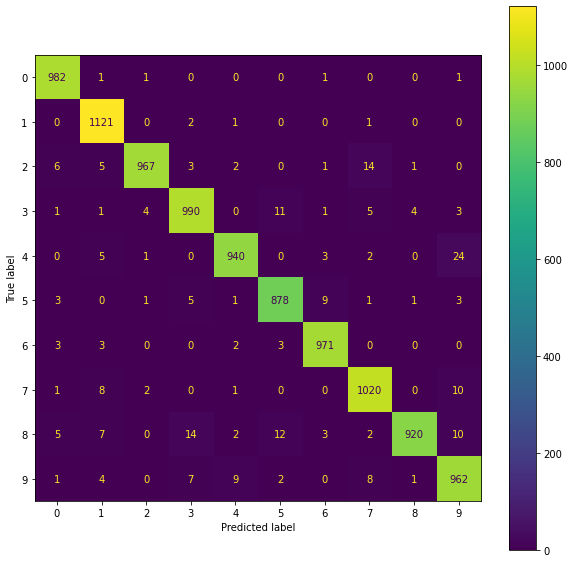

In [476]:
plt.figure(figsize=(10,10))
mnist_knn_final_cm = ConfusionMatrixDisplay.from_predictions(y_test,mnist_knn_final_yhat_test,ax=plt.gca())
plt.show()

In [479]:
mnist_knn_final_cm = confusion_matrix(y_test,mnist_knn_final_yhat_test)
mnist_knn_final_cm

array([[ 982,    1,    1,    0,    0,    0,    1,    0,    0,    1],
       [   0, 1121,    0,    2,    1,    0,    0,    1,    0,    0],
       [   6,    5,  967,    3,    2,    0,    1,   14,    1,    0],
       [   1,    1,    4,  990,    0,   11,    1,    5,    4,    3],
       [   0,    5,    1,    0,  940,    0,    3,    2,    0,   24],
       [   3,    0,    1,    5,    1,  878,    9,    1,    1,    3],
       [   3,    3,    0,    0,    2,    3,  971,    0,    0,    0],
       [   1,    8,    2,    0,    1,    0,    0, 1020,    0,   10],
       [   5,    7,    0,   14,    2,   12,    3,    2,  920,   10],
       [   1,    4,    0,    7,    9,    2,    0,    8,    1,  962]],
      dtype=int64)

In [508]:
mnist_knn_final_cm = mnist_knn_final_cm/mnist_knn_final_cm.sum(axis=1,keepdims=True)

In [509]:
np.fill_diagonal(mnist_knn_final_cm,0)

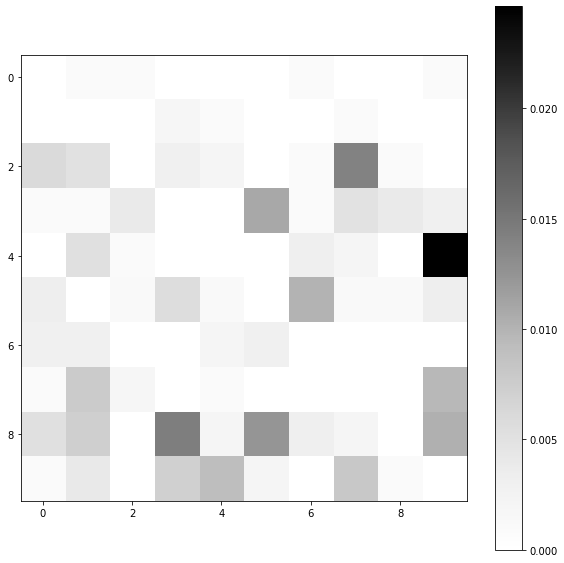

In [519]:
plt.figure(figsize=(10,10))
plt.imshow(mnist_knn_final_cm,cmap='Greys')
plt.colorbar()

We can notice that there's a relatively high confusion of actual 4 to 9 by our model.\
That is around 0.025, which translates to around 25 false 9 every 1000 predictions.

### Image Augmentation

We will write a transformer to perform data augmentation.\
Shift each image by 1 pixel for each direction, then return the datasets with the original image plus the augmented images.

In [854]:
class ImageAugmentor(BaseEstimator,TransformerMixin):
    def __init__(self,rows,columns):
        self.r = rows
        self.c = columns
        self._r_zero = np.zeros((1,self.c))
        self._c_zero = np.zeros((self.r,1))
        self._augmented_images = []
        self._augmented_labels = []
        self._X = None
        self._X_fitted = False
        self._y = None
        self._y_fitted = False
        return None
    def fit(self,X,y=None):
        if type(X) == pd.DataFrame:
            self._X = X.values
        elif type(X) == np.ndarray:
            self._X = X
        else:
            raise ValueError('Input X must be in DataFrame or 2D ndarray.')
        self._X_fitted = True
        
        if type(y) == pd.Series:
            self._y = y.values
        elif type(y) == np.ndarray:
            self._y = y
        elif not y:
            pass
        else:
            raise ValueError('Input y must be in Series or 1D ndarray.')
        self._y_fitted = True
        
        return self
    def transform(self,X,y=None):
        if self._X_fitted == False:
            raise ValueError('Please fit the data before transforming.')
        self._augmented_images = []
        self._augmented_labels = []
        
        for x,label in zip(self._X,self._y):
            x = x.reshape((self.r,self.c))
            
            self._augmented_images.append(np.concatenate((x[:,1:],self._c_zero),axis=1).flatten())
            self._augmented_images.append(np.concatenate((self._c_zero,x[:,:-1]),axis=1).flatten())
            self._augmented_images.append(np.concatenate((x[1:,:],self._r_zero),axis=0).flatten())
            self._augmented_images.append(np.concatenate((self._r_zero,x[:-1,:]),axis=0).flatten())
            if self._y_fitted: [self._augmented_labels.append(label) for i in range(4)]
        if not self._y_fitted:
            return np.concatenate((self._X,np.asarray(self._augmented_images)),axis=0)
        elif self._y_fitted:
            return np.concatenate((self._X,np.asarray(self._augmented_images)),axis=0),np.concatenate((self._y,np.asarray(self._augmented_labels)))

Let's use the image augmenter we just created to augment the dataset with 1 pixel shifting to each direction

In [866]:
augmenter = ImageAugmentor(28,28)

In [867]:
X_train_aug,y_train_aug = augmenter.fit_transform(X_train,y_train)

In [869]:
X_train_aug.shape,y_train_aug.shape

((300000, 784), (300000,))

#### Saving the datasets

In [897]:
savingpath = "Datasets\\"
joblib.dump(X_train_aug,savingpath+"X_train_aug.pkl",compress=9)
joblib.dump(y_train_aug,savingpath+"y_train_aug.pkl",compress=9)

['Datasets\\y_train_aug.pkl']

Now let's train our model with the augmented dataset

In [879]:
mnist_knn_final_aug = clone(mnist_knn_final)
mnist_knn_final_aug

Pipeline(steps=[('scaler', MyScaler(scalertype='skip')),
                ('knn',
                 KNeighborsClassifier(n_neighbors=3, weights='distance'))])

In [881]:
mnist_knn_final_aug.fit(X_train_aug,y_train_aug)

Pipeline(steps=[('scaler', MyScaler(scalertype='skip')),
                ('knn',
                 KNeighborsClassifier(n_neighbors=3, weights='distance'))])

In [884]:
mnist_knn_final_aug_yhat_test = mnist_knn_final_aug.predict(X_test)

In [885]:
mnist_knn_final_aug_acc = accuracy_score(y_test,mnist_knn_final_aug_yhat_test)
mnist_knn_final_aug_acc

0.9799

The accuracy score now has increased by another 0.5%

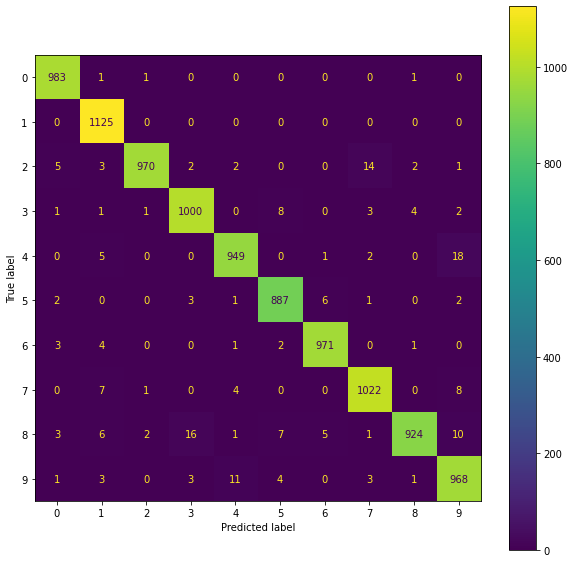

In [886]:
plt.figure(figsize=(10,10))
mnist_knn_final_aug_cmdisp = ConfusionMatrixDisplay.from_predictions(y_test,mnist_knn_final_aug_yhat_test,ax=plt.gca())
plt.show()

In [887]:
mnist_knn_final_aug_cm = confusion_matrix(y_test,mnist_knn_final_aug_yhat_test)
mnist_knn_final_aug_cm

array([[ 983,    1,    1,    0,    0,    0,    0,    0,    1,    0],
       [   0, 1125,    0,    0,    0,    0,    0,    0,    0,    0],
       [   5,    3,  970,    2,    2,    0,    0,   14,    2,    1],
       [   1,    1,    1, 1000,    0,    8,    0,    3,    4,    2],
       [   0,    5,    0,    0,  949,    0,    1,    2,    0,   18],
       [   2,    0,    0,    3,    1,  887,    6,    1,    0,    2],
       [   3,    4,    0,    0,    1,    2,  971,    0,    1,    0],
       [   0,    7,    1,    0,    4,    0,    0, 1022,    0,    8],
       [   3,    6,    2,   16,    1,    7,    5,    1,  924,   10],
       [   1,    3,    0,    3,   11,    4,    0,    3,    1,  968]],
      dtype=int64)

In [888]:
mnist_knn_final_aug_cm = mnist_knn_final_aug_cm/mnist_knn_final_aug_cm.sum(axis=1,keepdims=True)

In [889]:
np.fill_diagonal(mnist_knn_final_aug_cm,0)

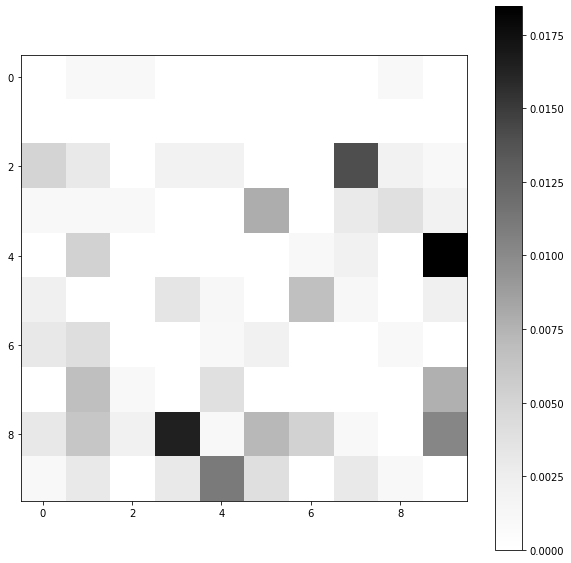

In [890]:
plt.figure(figsize=(10,10))
plt.imshow(mnist_knn_final_aug_cm,cmap='Greys')
plt.colorbar()

From this confusion matrix, we can clearly see an improvement (maybe not much, but definitely is).\
The darkest square is at (9,4) and (3,8). We can see that its rate of happening is now down to 0.018 from previously 0.025 highest.\

**Conclusion**:

To further improve the accuracy of this model, we can fit the more samples for number 3,4,8 and 9 to our model.\
So that it can distinguish these look-alike numbers accurately.

I am going to stop here as the accuracy of 98% is more than enough to fulfill the purpose of this exercise.

## Saving the trained model

In [893]:
mnist_knn_final_aug_scores = {
    "mnist_knn_final_aug_acc":mnist_knn_final_aug_acc,
    "mnist_knn_final_aug_cm":mnist_knn_final_aug_cm,
    "mnist_knn_final_aug_cmdisp":mnist_knn_final_aug_cmdisp,
}

In [896]:
dump_model(mnist_knn_final_aug,"mnist_knn_final_aug",mnist_knn_final_aug_yhat_test,mnist_knn_final_aug_scores)